In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


#### Импортируем необходимые для работы библиотеки, функции и классы

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Подключение предупреждений

In [3]:
import warnings
warnings.filterwarnings('ignore')

#### Приводим к единому стандарту оформления шрифтов

In [4]:
matplotlib.rcParams.update({'font.size': 14})

#### Задаем функцию подсчёта метрик

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Пропишем путь к файлам данных

In [6]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

#### Читаем данные

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


#### Проверяем типы даннных

In [8]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

#### Производим деление прзнаков на текстовые и числовые

In [9]:
num_feat = list(train_df.select_dtypes(exclude='object').columns)
obj_feat = list(train_df.select_dtypes(include='object').columns)
target = 'Price'

num_feat

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price']

#### Подгружаем текстовые данные

In [10]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


#### 10. выявляем кол-во строк в train и test

In [11]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


в обучающей выборке на один признак больше, чем в тестовой

In [12]:
train_df.shape[1] - 1 == test_df.shape[1]

True

In [13]:
submission_df = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')

##### **Приведение типов**

In [14]:
train_df['Id'] = train_df['Id'].astype(str)

##### **Поиск выбросов**

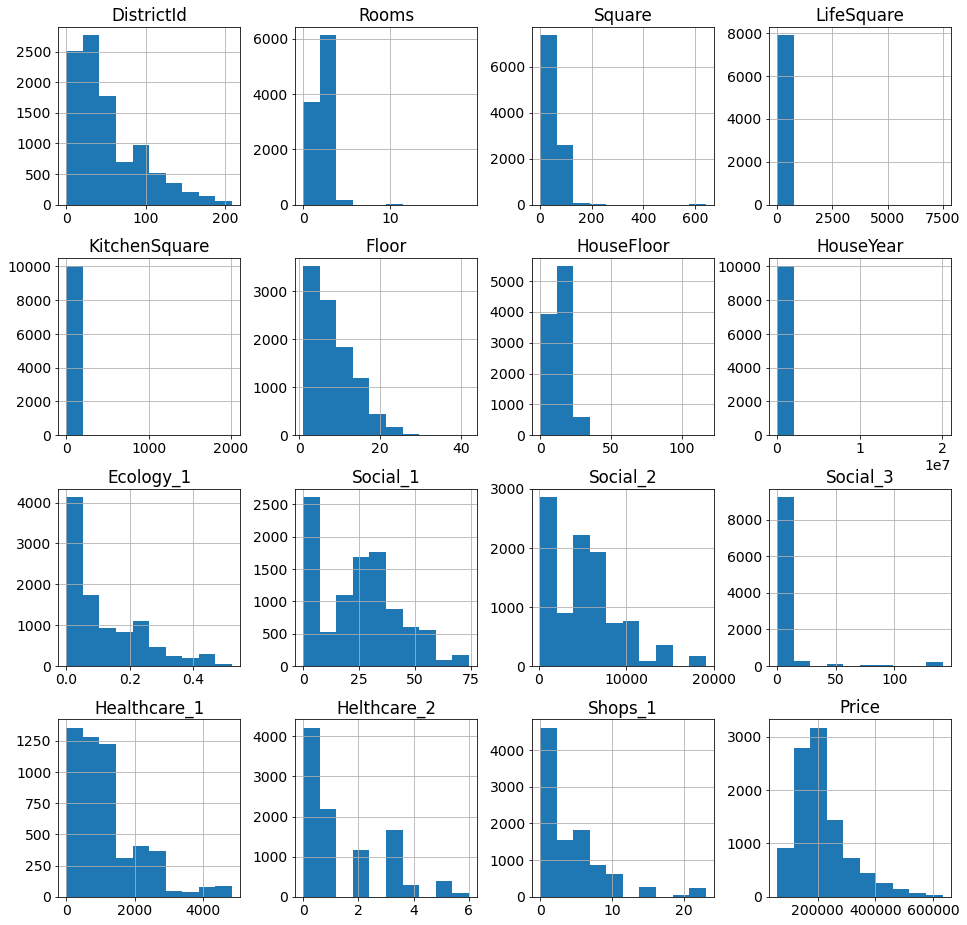

In [15]:
train_df[num_feat].hist(
    figsize=(16,16)
)
plt.show()

##### Выбросы присутствуют в следующих признаках - HouseYear, KitchenSquare. Так же в следующих признаках имеются аномалии которые необходимо редуцировать - HouseFloor, LifeSquare, Rooms, Square.

In [16]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01


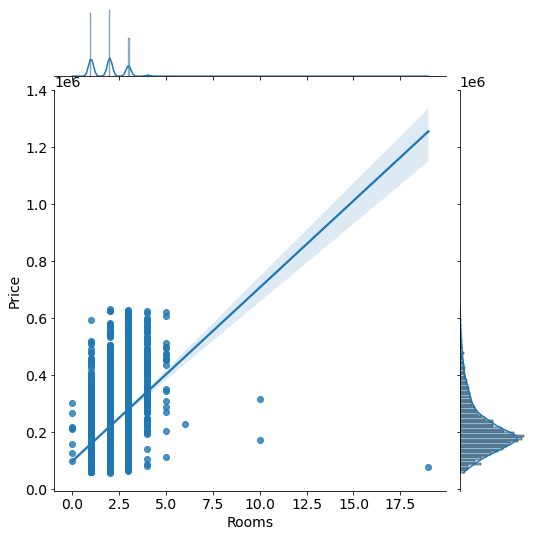

In [17]:
grid = sns.jointplot(train_df['Rooms'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

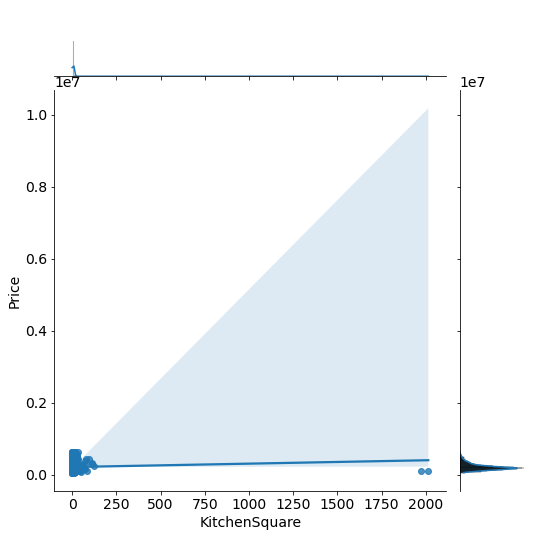

In [18]:
grid = sns.jointplot(train_df['KitchenSquare'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

Необходимо невилировать значения ниже 1 и выше 250 

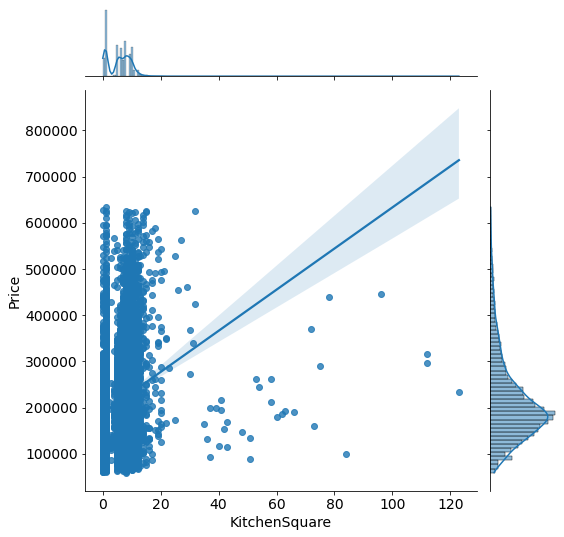

In [19]:
train_df_temp = train_df.loc[train_df['KitchenSquare']<250]
grid = sns.jointplot(train_df_temp['KitchenSquare'], train_df_temp['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

Как видно из полученной зависимости значения площади кухни менее 3 и выше 30 кв.м необходимо принять за выброс

#### Строим распределение целевой переменной  Price

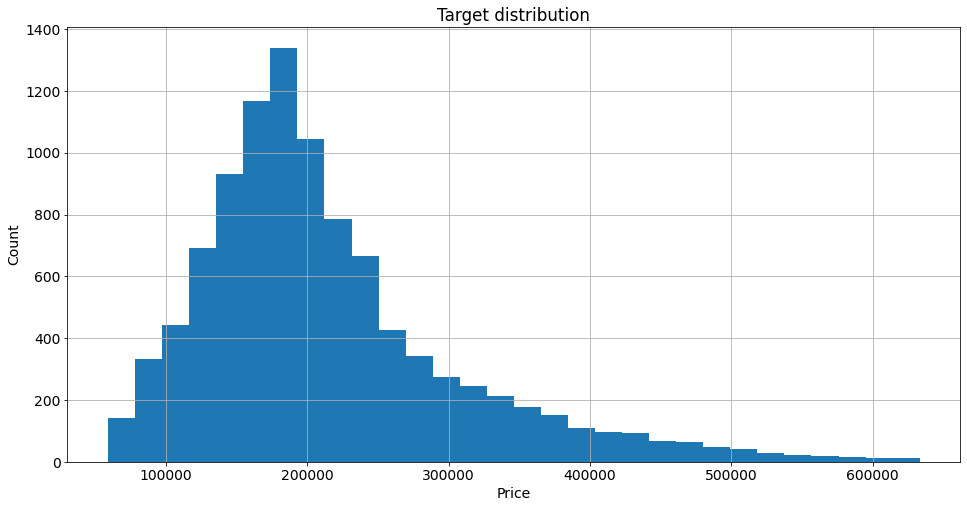

In [20]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Выявление главного признака

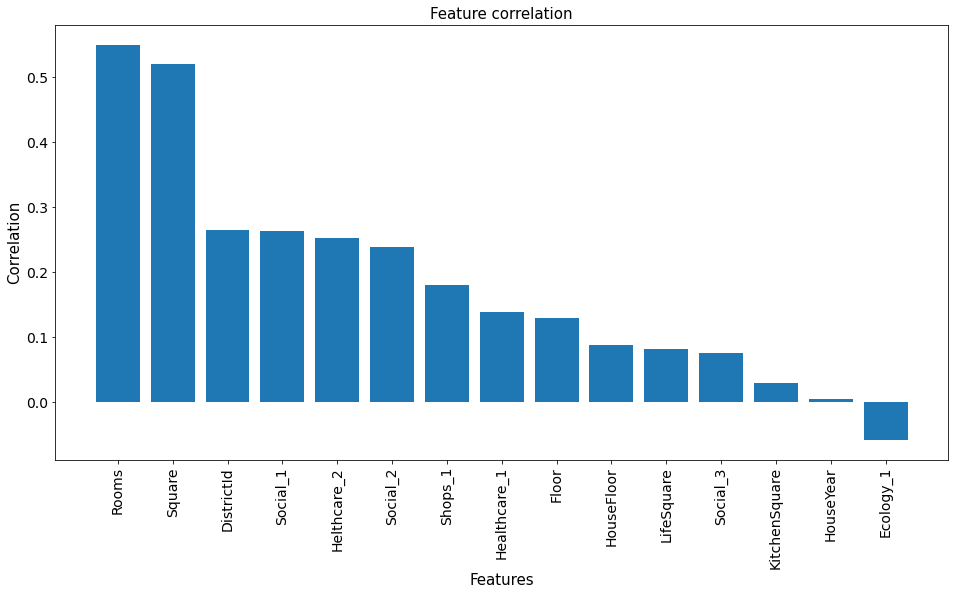

In [21]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()


#### Зададим класс для подготовки данных

In [22]:
class Data:
    
    def __init__(self):
        """Задаем релятивные интервалы значений для обработки выбросов на основе анализа данных"""
        self.Square_min = 15
        self.Square_max = 300
        
        self.LifeSquare_min = 10
        self.LifeSquare_max = 280
        
        self.Rooms_min = 1
        self.Rooms_max = 5
        
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
        
        self.KitchenSquare_min = 3
        self.KitchenSquare_max = 30
        
        self.current_year = datetime.now().year
        
        self.medians = None
        self.DistrictId_value_counts = None
        self.SquareMeterPrice_by_DistrictId = None
        self.Healthcare_1_by_DistrictId = None
        
        
    def fit(self, train_df):
        
        # медианы
        self.medians = train_df[['LifeSquare', 'HouseFloor']].median()
        
        # подсчет популярных районов
        self.DistrictId_value_counts = dict(train_df['DistrictId'].value_counts())
        
        # подсчет средней цены за м2 по району
        train_df_temp = train_df.loc[((train_df['Square'] > self.Square_min) & (train_df['Square'] < self.Square_max))]
        train_df_temp["SquareMeterPrice"] = train_df_temp["Price"] / train_df_temp["Square"]
        self.SquareMeterPrice_by_DistrictId = train_df_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        
        # подсчет среднего значения признака Healthcare_1 по району
        self.Healthcare_1_by_DistrictId = train_df.groupby('DistrictId', as_index=False)\
            .agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})
        
        del train_df_temp
        
    def transform(self, train_df):
        
        # Обработка пропусков
        train_df[['LifeSquare', 'HouseFloor']] = train_df[['LifeSquare', 'HouseFloor']].fillna(self.medians)
        
        # Обработка выбросов
        
        # площадь
        train_df.loc[(train_df['Square'] > self.Square_max), 'Square'] = self.Square_max
        train_df.loc[(train_df['Square'] < self.Square_min), 'Square'] = self.Square_min
        
        # жилая площадь
        train_df.loc[(train_df['LifeSquare'] < self.LifeSquare_min), 'LifeSquare'] = self.LifeSquare_min
        train_df.loc[(train_df['LifeSquare'] > self.LifeSquare_max), 'LifeSquare'] = self.LifeSquare_max
        
        # площадь кухни
        train_df.loc[(train_df['KitchenSquare'] < self.KitchenSquare_min), 'KitchenSquare'] = self.KitchenSquare_min
        train_df.loc[(train_df['KitchenSquare'] > self.KitchenSquare_max), 'KitchenSquare'] = self.KitchenSquare_max
        
        # год постройки дома
        train_df.loc[(train_df['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year
        
        # количество комнат
        train_df.loc[(train_df['Rooms'] > self.Rooms_max), 'Rooms'] = self.Rooms_max
        train_df.loc[(train_df['Rooms'] < self.Rooms_min), 'Rooms'] = self.Rooms_min
        
        # количество этажей
        train_df.loc[(train_df['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        train_df.loc[(train_df['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        # если этаж больше этажности дома, то присваиваем случайный этаж от self.HouseFloor_min до максимального этажа в доме
        floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
        train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: self.HouseFloor_min if (self.HouseFloor_min == x) else np.random.randint(self.HouseFloor_min, x))
        
        # Обработка категорий
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        return train_df
    
    def features(self, train_df):
        
        # добавление признака популярности района
        train_df['DistrictId_counts'] = train_df['DistrictId'].map(self.DistrictId_value_counts)
        train_df['DistrictId_counts'].fillna(train_df['DistrictId_counts'].median(), inplace=True)
        
        # добавление признака средней стоимости м2 по району
        train_df = train_df.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        train_df['AverageSquareMeterPrice'].fillna(train_df['AverageSquareMeterPrice'].median(), inplace=True)
        
        # добавление признака среднего значения Healthcare_1 по району
        train_df = train_df.merge(self.Healthcare_1_by_DistrictId, on=["DistrictId"], how='left')
        train_df['AverageHealthcare_1'].fillna(train_df['AverageHealthcare_1'].median(), inplace=True)
        
        return train_df

Инициализация класса Data

In [23]:
data_inst = Data()

# тренировочные данные
data_inst.fit(train_df)
train_df = data_inst.transform(train_df)
train_df = data_inst.features(train_df)

# тестовые данные
test_df = data_inst.transform(test_df)
test_df = data_inst.features(test_df)

Задаем список признаков для модели

In [24]:
feature_names = ['AverageSquareMeterPrice', 'DistrictId_counts', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
                    'HouseFloor', 'HouseYear', 'Helthcare_2', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                    'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
                    'AverageHealthcare_1']
target_name = 'Price'

In [25]:
train_df = train_df[feature_names + [target_name]]
test_df = test_df[feature_names + ['Id']]
X = train_df[feature_names]
y = train_df[target_name]

#### Обучение модели при помощи CatBoostRegressor

In [26]:
final_model = CatBoostRegressor(
    silent=True,
    learning_rate=0.1,
    iterations=1150,
    eval_metric='R2',
    depth=8
)

final_model.fit(X, y)

cv_score = cross_val_score(
    final_model,
    X,
    y,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

Оценка метрики

In [27]:
print(f'R2: {round(cv_score.mean(), 3)}')

R2: 0.756


#### Производим сортировку признаков согласно релевантности начальной задачи

In [28]:
feature_importances = pd.DataFrame(
    zip(X.columns, final_model.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(20)

,feature_name,importance
3,Square,28.320326
0,AverageSquareMeterPrice,18.263690
8,HouseYear,8.251486
5,KitchenSquare,5.304506
4,LifeSquare,4.627424
7,HouseFloor,4.164886
1,DistrictId_counts,4.086663
12,Social_2,4.076184
10,Ecology_1,4.039116
6,Floor,4.002258


#### Создаем датафрейм с предиктивными данными

In [29]:
preds_final = pd.DataFrame()
preds_final['Id'] = test_df['Id'].copy()

test_df.set_index('Id', inplace=True)
test_df = test_df[feature_names]

In [30]:
y_pred_final = final_model.predict(test_df)

submission_df['Price'] = y_pred_final
submission_df.to_csv('./predictions.csv', index=False, encoding='utf-8', sep=',')

submission_df.head()

,Id,Price
0,4567,168491.762267
1,5925,111128.202881
2,960,139746.120192
3,3848,94878.508169
4,746,165251.116138
